# High-level PyTorch Example

In [1]:
import os
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn.init as init
from torch.autograd import Variable
from common.params import *
from common.utils import *
from gpumon import log_context
from IPython.display import SVG, display
from bokeh.io import export_svgs
import pip

In [2]:
from bokeh.io import output_notebook, show

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
# Big impact on training-time (from 350 to 165s)
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [5]:
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("GPU: ", get_gpu_name())

OS:  linux
Python:  3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_4
Numpy:  1.13.1
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']


In [6]:
class SymbolModule(nn.Module):
    def __init__(self):
        super(SymbolModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
        # feature map size is 8*8 by pooling
        self.fc1 = nn.Linear(100*8*8, 512)
        self.fc2 = nn.Linear(512, N_CLASSES)

    def forward(self, x):
        """ PyTorch requires a flag for training in dropout """
        x = self.conv2(F.relu(self.conv1(x)))
        x = F.relu(F.max_pool2d(x, kernel_size=2, stride=2))
        x = F.dropout(x, 0.25, training=self.training)

        x = self.conv4(F.relu(self.conv3(x)))
        x = F.relu(F.max_pool2d(x, kernel_size=2, stride=2))
        x = F.dropout(x, 0.25, training=self.training)

        x = x.view(-1, 100*8*8)   # reshape Variable
        x = F.dropout(F.relu(self.fc1(x)), 0.5, training=self.training)
        # nn.CrossEntropyLoss() contains softmax, don't apply twice
        #return F.log_softmax(x)
        return self.fc2(x)

In [7]:
def init_model(m):
    # Implementation of momentum:
    # v = \rho * v + g \\
    # p = p - lr * v
    opt = optim.SGD(m.parameters(), lr=LR, momentum=MOMENTUM)
    criterion = nn.CrossEntropyLoss()
    return opt, criterion

In [8]:
%%time
# Data into format for library
x_train, x_test, y_train, y_test = cifar_for_library(channel_first=True)
# Torch-specific
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

Done.
Extracting files...
Done.
Preparing train set...
Preparing test set...
Done.
(50000, 3, 32, 32) (10000, 3, 32, 32) (50000,) (10000,)
float32 float32 int64 int64
CPU times: user 3.36 s, sys: 1.72 s, total: 5.08 s
Wall time: 43 s


In [9]:
%%time
sym = SymbolModule()
sym.cuda() # CUDA!

CPU times: user 1.81 s, sys: 2.42 s, total: 4.23 s
Wall time: 5.26 s


In [10]:
%%time
optimizer, criterion = init_model(sym)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 246 µs


In [11]:
%%time
with log_context('pytorch.txt') as log:
    # Sets training = True
    sym.train()  
    for j in range(EPOCHS):
        for data, target in yield_mb(x_train, y_train, BATCHSIZE, shuffle=True):
            # Get samples
            data = Variable(torch.FloatTensor(data).cuda())
            target = Variable(torch.LongTensor(target).cuda())
            # Init
            optimizer.zero_grad()
            # Forwards
            output = sym(data)
            # Loss
            loss = criterion(output, target)
            # Back-prop
            loss.backward()
            optimizer.step()
        # Log
        print(j)

0
1
2
3
4
5
6
7
8
9
CPU times: user 1min 31s, sys: 15 s, total: 1min 46s
Wall time: 1min 48s


In [12]:
p = log.plot()

In [13]:
show(p)

In [14]:
installed_packages = [package.project_name for package in pip.get_installed_distributions()]

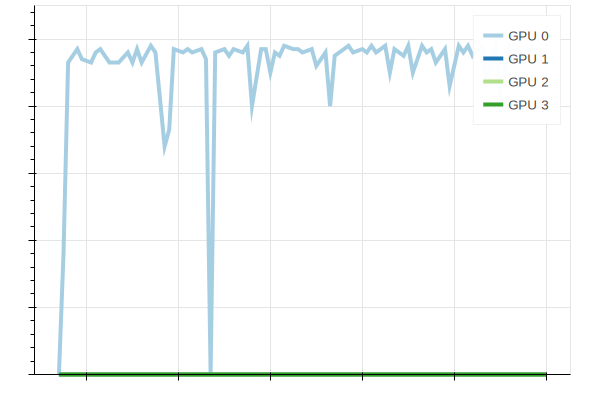

In [16]:
if 'selenium' in installed_packages:
    p.output_backend = "svg"
    export_svgs(p, filename="pytorch.svg")
    display(SVG('pytorch.svg'))

In [20]:
%%time
# Test model
# Sets training = False
sym.eval()
n_samples = (y_test.shape[0]//BATCHSIZE)*BATCHSIZE
y_guess = np.zeros(n_samples, dtype=np.int)
y_truth = y_test[:n_samples]
c = 0
for data, target in yield_mb(x_test, y_test, BATCHSIZE):
    # Get samples
    data = Variable(torch.FloatTensor(data).cuda())
    # Forwards
    output = sym(data)
    pred = output.data.max(1)[1].cpu().numpy().squeeze()
    # Collect results
    y_guess[c*BATCHSIZE:(c+1)*BATCHSIZE] = pred
    c += 1

CPU times: user 788 ms, sys: 100 ms, total: 888 ms
Wall time: 886 ms


In [21]:
print("Accuracy: ", sum(y_guess == y_truth)/len(y_guess))

Accuracy:  0.774138621795
